<a href="https://colab.research.google.com/github/SanjayGanapathy/HousePricePrediction/blob/main/Turkey_vulture_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection and Feature Relation with Turkey Vulture Migration Data**



* This Colab Notebook is meant to explore anomalous data and environmental variable relations in migration patterns with Turkey Vulture Movement Data.
* The prupose of this code is to try to determine what environmental variables are affecting or being affected by Turkey Vulture movement.  
* This information can reveal environmental issues like a lack of food, habitat loss, or even climate change affecting the birds' migration patterns.
* The primary method of detection is using Machine Learning Anomaly Detection.


In [9]:
#Imports
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import json
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
!pip install contextily
import contextily as ctx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from prettytable import PrettyTable
from geopy.distance import geodesic

# **EDA**


Data types of each column:
timestamp                  object
location-long             float64
location-lat              float64
eobs.temperature            int64
ground.speed              float64
heading                   float64
height.above.ellipsoid    float64
identifier                  int64
temperature_celsius       float64
wind_speed                float64
wind_direction_degrees    float64
distance_from_land        float64
npp                       float64
dtype: object

Summary statistics for numerical columns:


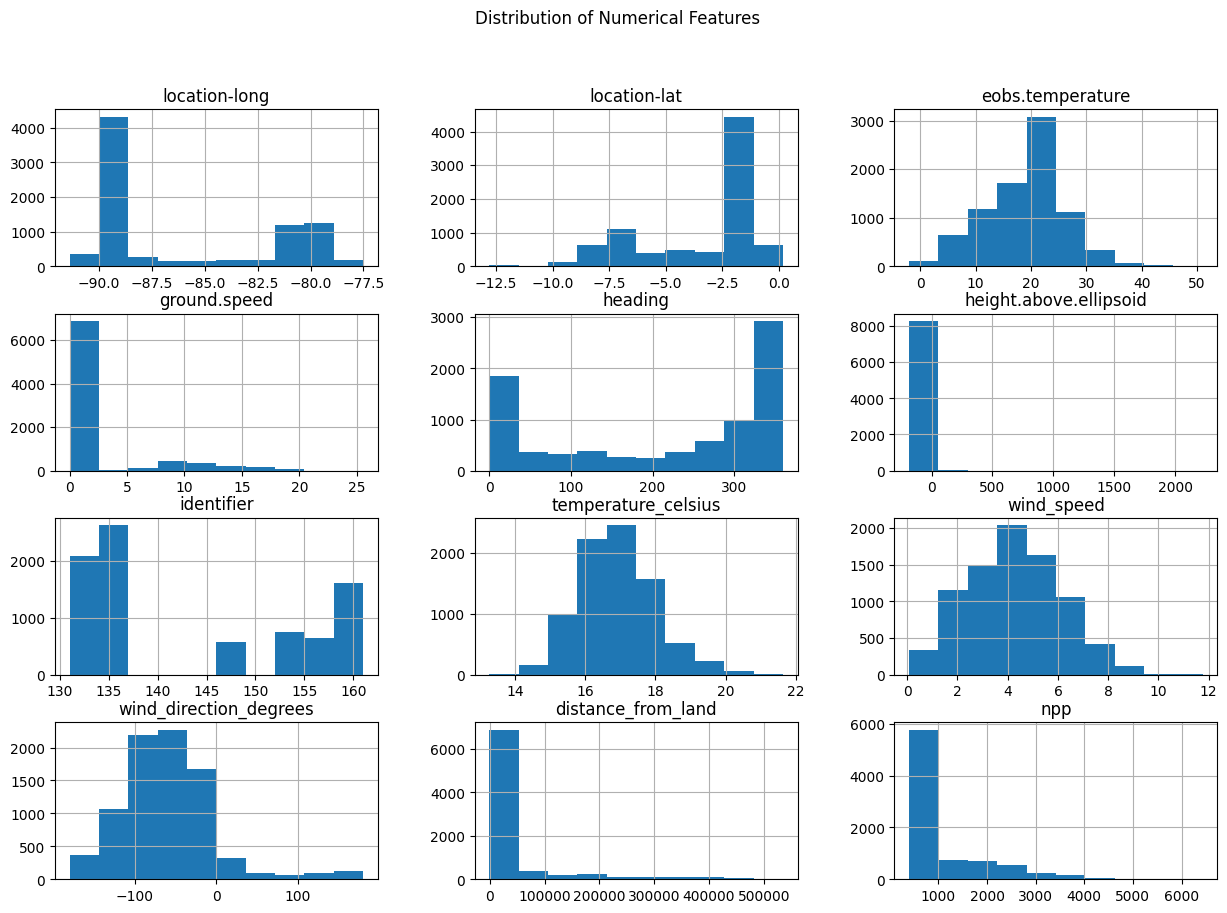

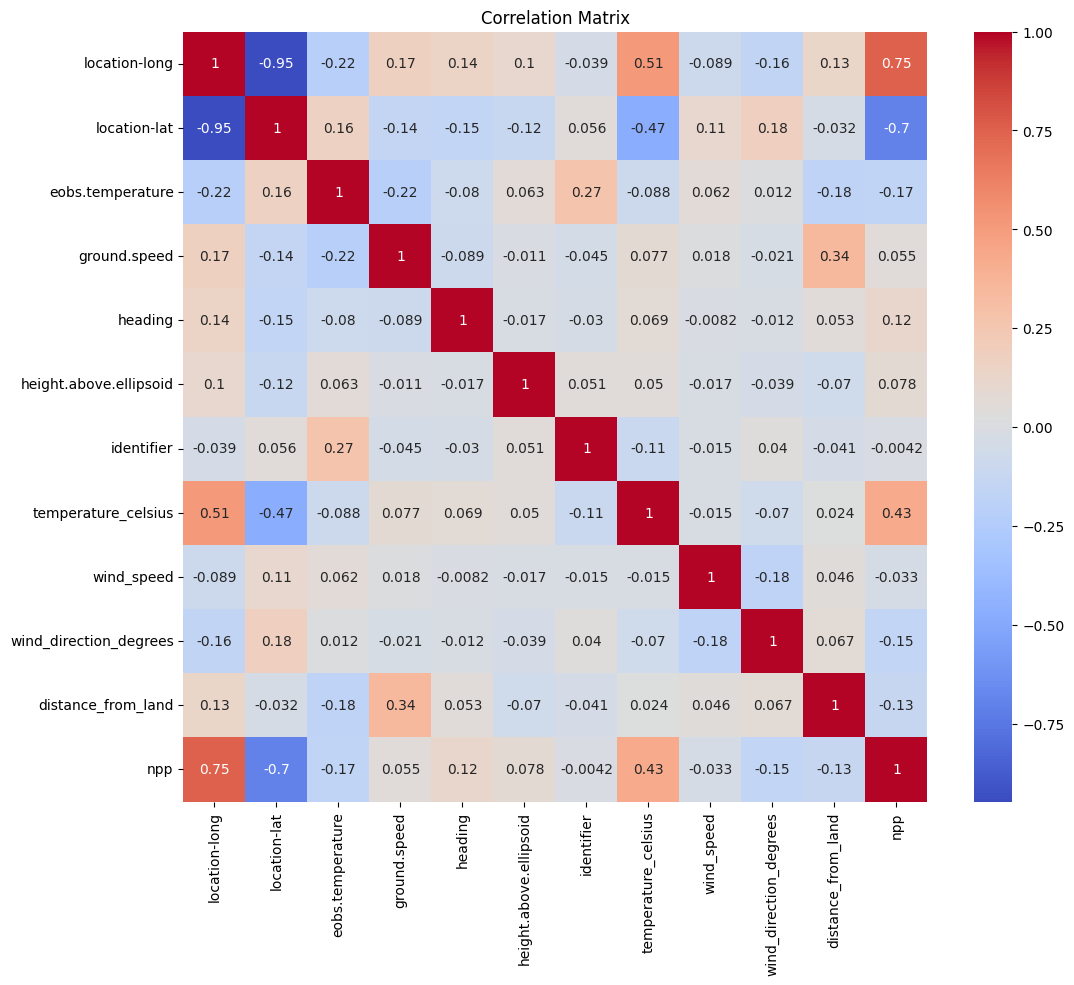

In [10]:
# Load the data
df = pd.read_csv('/content/Turkey_Vulture.csv')

# Step 3: Data types
print("\nData types of each column:")
print(df.dtypes)

# Step 4: Summary statistics
print("\nSummary statistics for numerical columns:")
df.describe()
df.drop(columns=['identifier'])
# Step 5: Distribution of numerical features
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns].hist(figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Step 6: Correlation matrix
correlation_matrix = df[numerical_columns].corr()

plt.figure(figsize=(12, 10))  # Adjust the width and height as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [11]:
df.head()

,timestamp,location-long,location-lat,eobs.temperature,ground.speed,heading,height.above.ellipsoid,identifier,temperature_celsius,wind_speed,wind_direction_degrees,distance_from_land,npp
0,2008-05-31 13:30:02,-89.74021,-1.372641,12,0.01,21.63,16.5,131,15.33841,4.142904,-157.2987,1397.167,475.0168
1,2008-05-31 15:00:44,-89.74015,-1.372894,19,0.00,95.68,12.6,131,15.50378,3.884221,-157.6905,1397.167,474.2830
2,2008-05-31 16:30:39,-89.74014,-1.372881,24,0.11,13.76,17.4,131,15.66776,3.628111,-158.1358,1397.167,473.6378
3,2008-05-31 18:00:49,-89.74016,-1.372891,18,0.20,9.83,24.8,131,15.83337,3.371246,-158.6367,1397.167,472.9805
4,2008-05-31 19:30:18,-89.74013,-1.372912,22,0.24,37.36,19.0,131,16.12421,3.085631,-157.6523,1397.167,472.3287


In [12]:
def visualize_anomalies(df, model, scaler, features, model_type, time_steps=10, threshold_percentile=95):
    # Create GeoDataFrame
    df_geo = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df['location-long'], df['location-lat'])
    )
    df_geo = df_geo.set_crs(epsg=4326)

    # Prepare data
    X = df[features].values
    X_scaled = scaler.transform(X)

    if model_type == '(RNN (C))':
        # Prepare data for RNN
        X_rnn = np.array([X_scaled[i: i + time_steps] for i in range(len(X_scaled) - time_steps + 1)])

        # Predict using the RNN model
        X_pred = model.predict(X_rnn)
        X_pred_reshaped = np.repeat(X_pred[:, np.newaxis, :], X_rnn.shape[1], axis=1)

        # Calculate loss and determine anomalies
        loss = np.mean(np.abs(X_rnn - X_pred_reshaped), axis=(1, 2))
        threshold = np.percentile(loss, threshold_percentile)
        anomalies = loss > threshold

        # Add anomaly column to DataFrame
        df['anomaly'] = np.pad(anomalies, (time_steps - 1, 0), mode='constant', constant_values=False)

    elif model_type == '(Markov (D))':
        # Predict using the Markov Chain model
        anomalies = model.predict(X_scaled, df['ground.speed'].values)
        df['anomaly'] = anomalies == -1

    elif model_type == '(OCSVM (A))':
        # Predict using the OCSVM model
        anomalies = model.predict(X_scaled)
        df['anomaly'] = anomalies == -1

    elif model_type == '(Isolation Forest (B))':
        # Predict using the Isolation Forest model
        anomalies = model.predict(X_scaled)
        df['anomaly'] = anomalies == -1

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x=df['location-long'],
        y=df['location-lat'],
        c=df['speed_kmph'],  # Use speed as the color dimension
        cmap='viridis',
        s=20,
        alpha=0.6,
        edgecolor=df['anomaly'].map({False: 'blue', True: 'red'})  # Highlight anomalies
    )
    cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1)
    cbar.set_label('Flight Speed (Km/h)', labelpad=10)
    cbar.ax.xaxis.set_label_position('bottom')
    cbar.ax.xaxis.set_ticks_position('bottom')
    cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')

    ctx.add_basemap(plt.gca(), crs=df_geo.crs.to_string())
    plt.title(f'Anomalies Detected for Flight Speed {model_type}')
    plt.xlabel('Longitude (Degrees)')
    plt.ylabel('Latitude (Degrees)')

    # Add legend
    normal_patch = plt.scatter([], [], c='blue', label='Normal')
    anomaly_patch = plt.scatter([], [], c='red', label='Anomaly')
    plt.legend(handles=[normal_patch, anomaly_patch], title="Legend", loc='lower left')

    plt.show()


def split_data(X, test_size=0.2, val_size=0.1):
    X_train, X_temp = train_test_split(X, test_size=test_size, random_state=42)
    X_val, X_test = train_test_split(X_temp, test_size=val_size/(test_size+val_size), random_state=42)
    return X_train, X_val, X_test

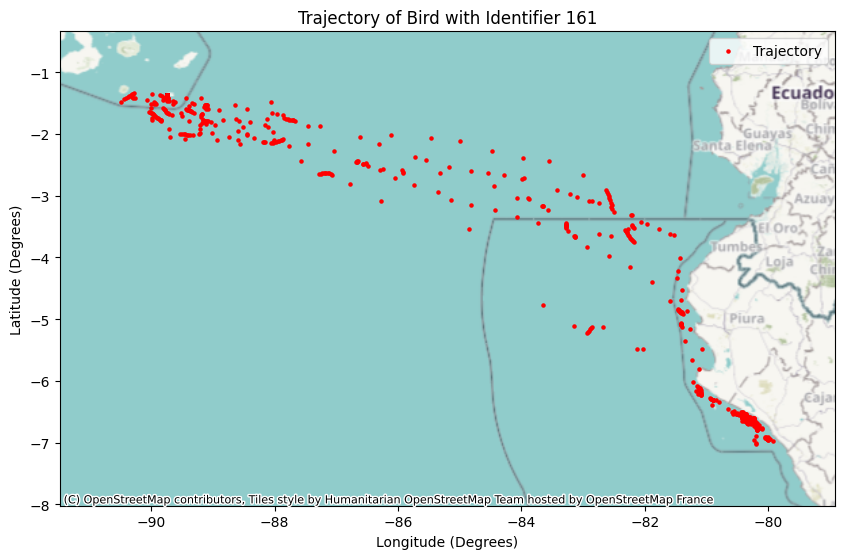

In [13]:
# Filter data for the bird with identifier 161
df_bird_161 = df[df['identifier'] == 161]

# Create a GeoDataFrame
df_geo = gpd.GeoDataFrame(
    df_bird_161, geometry=gpd.points_from_xy(df_bird_161['location-long'], df_bird_161['location-lat'])
)

# Set the coordinate reference system to WGS84 (latitude and longitude)
df_geo = df_geo.set_crs(epsg=4326)

# Plot the trajectory on the map
fig, ax = plt.subplots(figsize=(10, 10))
df_geo.plot(ax=ax, marker='o', color='red', markersize=5, label='Trajectory')

# Add basemap and set zoom level by adjusting the axis limits
ctx.add_basemap(ax, crs=df_geo.crs.to_string())
ax.set_xlim(df_geo.total_bounds[0] - 1, df_geo.total_bounds[2] + 1)  # Extend x-axis limits
ax.set_ylim(df_geo.total_bounds[1] - 1, df_geo.total_bounds[3] + 1)  # Extend y-axis limits

plt.title('Trajectory of Bird with Identifier 161')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')
plt.legend()
plt.show()


In [14]:
df_bird_161.head(2)

,timestamp,location-long,location-lat,eobs.temperature,ground.speed,heading,height.above.ellipsoid,identifier,temperature_celsius,wind_speed,wind_direction_degrees,distance_from_land,npp
3833,2008-05-31 13:29:31,-89.74023,-1.372912,24,0.01,327.02,25.8,161,15.33740,4.144246,-157.2950,1397.167,474.9309
3834,2008-05-31 13:30:12,-89.74023,-1.372905,25,0.13,7.86,24.8,161,15.33862,4.142299,-157.2978,1397.167,474.9282


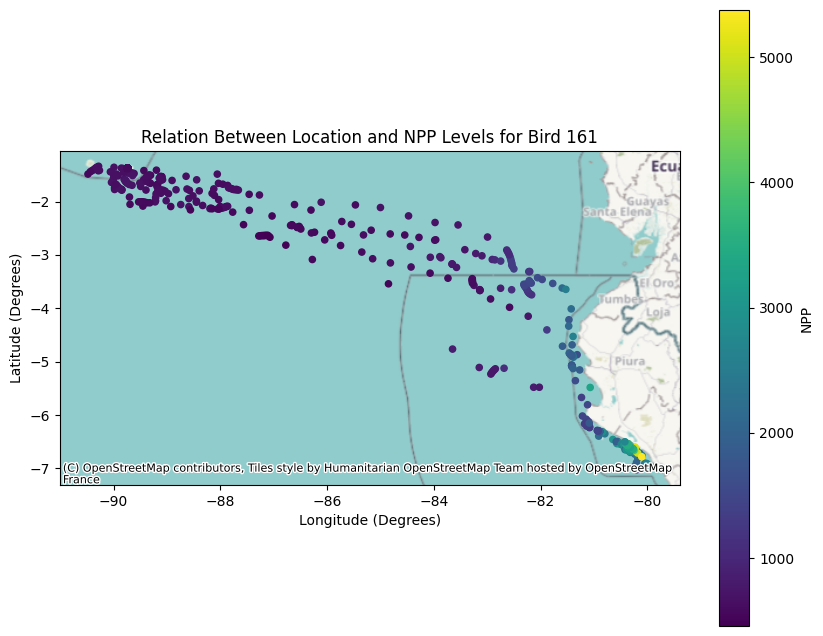

In [15]:
df_geo = gpd.GeoDataFrame(
    df_bird_161, geometry=gpd.points_from_xy(df_bird_161['location-long'], df_bird_161['location-lat'])
)

df_geo = df_geo.set_crs(epsg=4326)

# Plot the NPP levels on the OSM map
plt.figure(figsize=(10, 8))
plt.scatter(
    x=df_bird_161['location-long'],
    y=df_bird_161['location-lat'],
    c=df_bird_161['npp'],
    cmap='viridis',
    s=20
)
plt.colorbar(label='NPP')

# Add basemap using contextily with OSM tiles
ctx.add_basemap(plt.gca(), crs=df_geo.crs.to_string())

plt.title('Relation Between Location and NPP Levels for Bird 161')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')
plt.show()

In [16]:
df_bird_161['timestamp'] = pd.to_datetime(df_bird_161['timestamp'])

# Calculate distance and time difference
distances = []
time_diffs = []

# Use df_bird_161.index to iterate over the actual indices
for i in range(1, len(df_bird_161)):
    coords_1 = (df_bird_161.loc[df_bird_161.index[i-1], 'location-lat'], df_bird_161.loc[df_bird_161.index[i-1], 'location-long'])
    coords_2 = (df_bird_161.loc[df_bird_161.index[i], 'location-lat'], df_bird_161.loc[df_bird_161.index[i], 'location-long'])

    # Calculate distance between successive points
    distance = geodesic(coords_1, coords_2).meters
    distances.append(distance)

    # Calculate time difference in seconds
    time_diff = (df_bird_161.loc[df_bird_161.index[i], 'timestamp'] - df_bird_161.loc[df_bird_161.index[i-1], 'timestamp']).total_seconds()
    time_diffs.append(time_diff)

# Add distances and time_diffs to the dataframe
df_bird_161 = df_bird_161.iloc[1:].copy()  # Skip the first row as it doesn't have a preceding point to calculate distance
df_bird_161['distance'] = distances
df_bird_161['time_diff'] = time_diffs

# Calculate speed in kilometers per hour (km/h)
df_bird_161['speed_kmph'] = (df_bird_161['distance'] / df_bird_161['time_diff']) * 3.6

# Drop rows with NaN or infinite values in 'speed_kmph'
df_bird_161 = df_bird_161.replace([np.inf, -np.inf], np.nan).dropna(subset=['speed_kmph'])

<ipython-input-16-d6b0c5c2bdb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird_161['timestamp'] = pd.to_datetime(df_bird_161['timestamp'])


<ipython-input-17-5f2f4a074426>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')


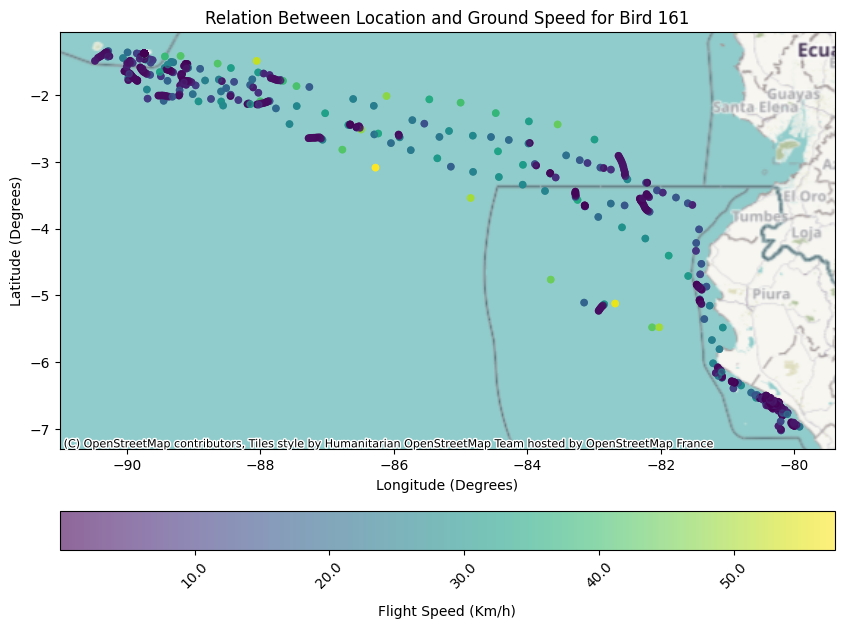

In [17]:
# Plot the ground speed on the OSM map
plt.figure(figsize=(10, 8))
plt.scatter(
    x=df_bird_161['location-long'],
    y=df_bird_161['location-lat'],
    c=df_bird_161['speed_kmph'],
    cmap='viridis',
    s=20
)

scatter = plt.scatter(
      x=df_bird_161['location-long'],
      y=df_bird_161['location-lat'],
      c=df_bird_161['speed_kmph'],
      cmap='viridis',
      s=20,
      alpha=0.6,
)
cbar = plt.colorbar(scatter, orientation='horizontal', pad=0.1)
cbar.set_label('Flight Speed (Km/h)', labelpad=10)
cbar.ax.xaxis.set_label_position('bottom')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')

# Add basemap using contextily with OSM tiles
ctx.add_basemap(plt.gca(), crs=df_geo.crs.to_string())

plt.title('Relation Between Location and Ground Speed for Bird 161')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')
plt.show()


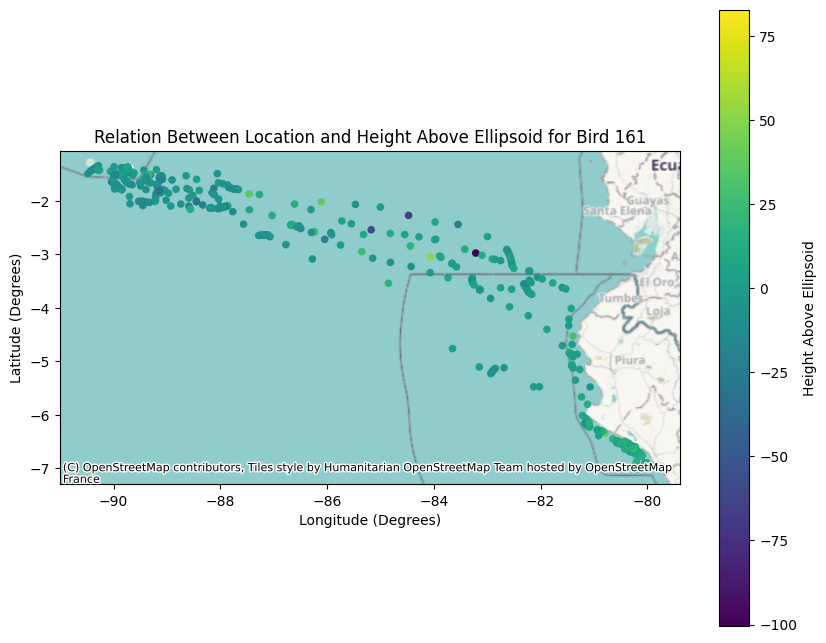

In [18]:
# Plot the height above ellipsoid on the OSM map
plt.figure(figsize=(10, 8))
plt.scatter(
    x=df_bird_161['location-long'],
    y=df_bird_161['location-lat'],
    c=df_bird_161['height.above.ellipsoid'],
    cmap='viridis',
    s=20
)
plt.colorbar(label='Height Above Ellipsoid')

# Add basemap using contextily with OSM tiles
ctx.add_basemap(plt.gca(), crs=df_geo.crs.to_string())

plt.title('Relation Between Location and Height Above Ellipsoid for Bird 161')
plt.xlabel('Longitude (Degrees)')
plt.ylabel('Latitude (Degrees)')
plt.show()


In [19]:
#Data preparation

features = ['ground.speed']
X = df_bird_161[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, X_test = split_data(X_scaled)


# **Isolation Forest**

<ipython-input-12-baf442bb9eee>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')


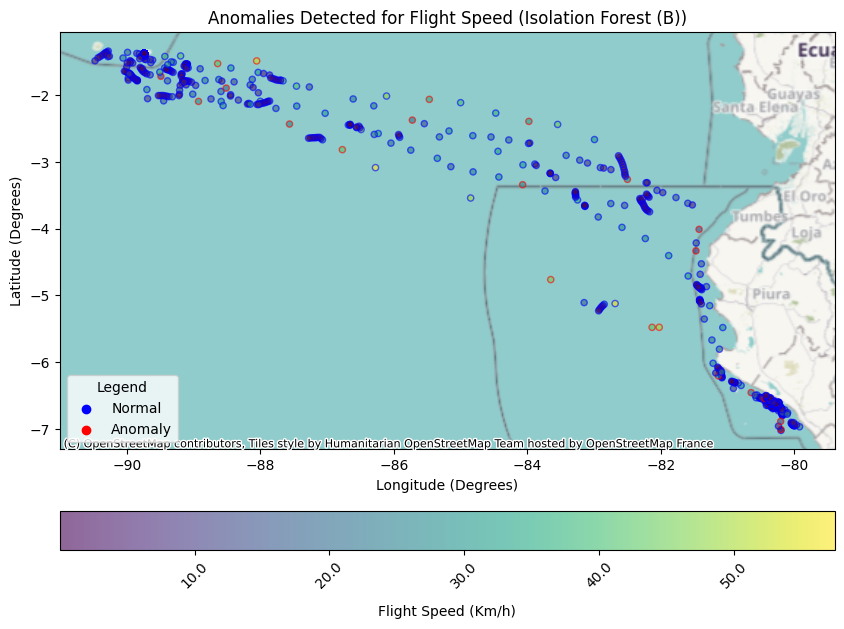

In [22]:
# Train the Isolation Forest model
if_model = IsolationForest(n_estimators=49, max_samples=200, contamination=0.025, random_state=50)
if_model.fit(X_train)

# Predict anomalies on the validation set
y_val_pred_if = if_model.predict(X_val)
y_val_pred_if = np.where(y_val_pred_if == 1, 0, 1)  # Map 1 to normal and -1 to anomaly

# Predict anomalies on the test set
y_test_pred_if = if_model.predict(X_test)
y_test_pred_if = np.where(y_test_pred_if == 1, 0, 1)  # Map 1 to normal and -1 to anomaly

visualize_anomalies(df_bird_161, if_model, scaler, features, model_type='(Isolation Forest (B))')


# **One Class Support Vector Machines (OCSVMs)**

<ipython-input-12-baf442bb9eee>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')


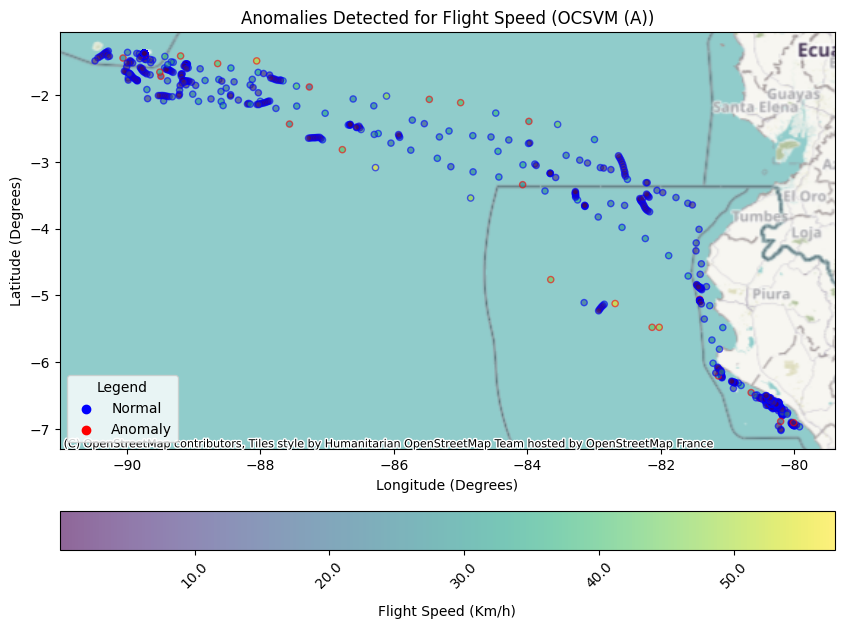

In [23]:
X_train, X_val, X_test = split_data(X_scaled)

ocsvm_model = OneClassSVM(kernel='rbf', nu=0.07, gamma=0.05)
ocsvm_model.fit(X_train)

# Predict anomalies on the validation set
y_val_pred_ocsvm = ocsvm_model.predict(X_val)
y_val_pred_ocsvm = np.where(y_val_pred_ocsvm == 1, 0, 1)  # Map 1 to normal and -1 to anomaly

# Predict anomalies on the test set
y_test_pred_ocsvm = ocsvm_model.predict(X_test)
y_test_pred_ocsvm = np.where(y_test_pred_ocsvm == 1, 0, 1)
visualize_anomalies(df_bird_161, ocsvm_model, scaler, features, model_type='(OCSVM (A))')


# **RNN**

In [24]:
# Function to split the data
def split_data(data, train_size=0.7, val_size=0.15):
    train_end = int(len(data) * train_size)
    val_end = train_end + int(len(data) * val_size)
    return data[:train_end], data[train_end:val_end], data[val_end:]

# Assuming `df_bird_161` is your dataset and `features` are the columns you're interested in
X = df_bird_161[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, X_test = split_data(X_scaled)


In [25]:
# Function to reshape the data for RNN input
def reshape_for_rnn(data, time_steps):
    return np.array([data[i: i + time_steps] for i in range(len(data) - time_steps)])

time_steps = 10  # Define the number of time steps for the RNN
X_train_rnn = reshape_for_rnn(X_train, time_steps)
X_val_rnn = reshape_for_rnn(X_val, time_steps)
X_test_rnn = reshape_for_rnn(X_test, time_steps)

# Build the RNN model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [26]:
# Train the model
history = model.fit(X_train_rnn, X_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, X_val_rnn))

Epoch 1/50
22/22 [==============================] - 5s 46ms/step - loss: 0.0336 - val_loss: 0.0499
Epoch 2/50
22/22 [==============================] - 0s 20ms/step - loss: 0.0276 - val_loss: 0.0478
Epoch 3/50
22/22 [==============================] - 0s 22ms/step - loss: 0.0267 - val_loss: 0.0459
Epoch 4/50
22/22 [==============================] - 0s 19ms/step - loss: 0.0262 - val_loss: 0.0459
Epoch 5/50
22/22 [==============================] - 0s 22ms/step - loss: 0.0259 - val_loss: 0.0459
Epoch 6/50
22/22 [==============================] - 0s 20ms/step - loss: 0.0258 - val_loss: 0.0455
Epoch 7/50
22/22 [==============================] - 0s 22ms/step - loss: 0.0263 - val_loss: 0.0455
Epoch 8/50
22/22 [==============================] - 0s 21ms/step - loss: 0.0257 - val_loss: 0.0454
Epoch 9/50
22/22 [==============================] - 0s 22ms/step - loss: 0.0256 - val_loss: 0.0452
Epoch 10/50
22/22 [==============================] - 1s 31ms/step - loss: 0.0256 - val_loss: 0.0452
Epoch 11/

In [27]:
# Predict anomalies on the validation set
X_val_pred_rnn = model.predict(X_val_rnn)
model.save('rnn_model.h5')
# Reshape X_val_pred to match X_val_rnn before calculating the loss
X_val_pred_reshaped = np.repeat(X_val_pred_rnn[:, np.newaxis, :], X_val_rnn.shape[1], axis=1)

# Calculate the loss
val_loss = np.mean(np.abs(X_val_rnn - X_val_pred_reshaped), axis=(1, 2))
val_threshold = np.percentile(val_loss, 95)
y_val_pred = np.where(val_loss > val_threshold, 1, 0)

# Predict anomalies on the test set
X_test_pred = model.predict(X_test_rnn)

# Reshape X_test_pred to match X_test_rnn before calculating the loss
X_test_pred_reshaped = np.repeat(X_test_pred[:, np.newaxis, :], X_test_rnn.shape[1], axis=1)

# Calculate the loss
test_loss = np.mean(np.abs(X_test_rnn - X_test_pred_reshaped), axis=(1, 2))
y_test_pred = np.where(test_loss > val_threshold, 1, 0)

5/5 [==============================] - 0s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 6ms/step


<ipython-input-12-baf442bb9eee>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')


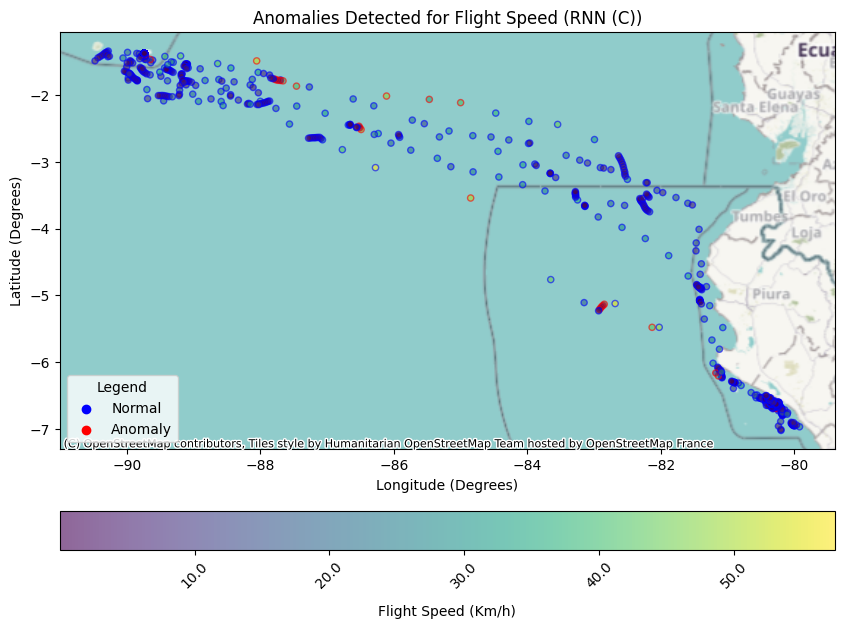

In [28]:
visualize_anomalies(df_bird_161, model, scaler, features, model_type='(RNN (C))')

# **Markov Chains**

In [29]:
class MarkovChainAnomalyDetector:
    def __init__(self, n_states=3, n_iterations=100, random_state=None):
        self.n_states = n_states
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.transition_matrix = None
        self.emission_params = None

    def fit(self, X):
        np.random.seed(self.random_state)
        if X.ndim == 2 and X.shape[1] == 1:
            X = X.ravel()  # Flatten 2D array with single column to 1D array
        n_samples = X.shape[0]
        # Initialize parameters
        self.transition_matrix = np.random.rand(self.n_states, self.n_states)
        self.transition_matrix /= self.transition_matrix.sum(axis=1, keepdims=True)
        self.emission_params = {
            'mean': np.random.rand(self.n_states),
            'std': np.random.rand(self.n_states)
        }

        for _ in range(self.n_iterations):
            # E-step
            responsibilities = self._compute_responsibilities(X)

            # M-step
            self._update_parameters(X, responsibilities)

    def _compute_responsibilities(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_states))

        for i in range(self.n_states):
            responsibilities[:, i] = np.exp(-(X - self.emission_params['mean'][i])**2 /
                                            (2 * self.emission_params['std'][i]**2)) / \
                                     (self.emission_params['std'][i] * np.sqrt(2 * np.pi))

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _update_parameters(self, X, responsibilities):
        for i in range(self.n_states):
            weight = responsibilities[:, i].sum()
            self.emission_params['mean'][i] = (responsibilities[:, i] * X).sum() / weight
            self.emission_params['std'][i] = np.sqrt(
                (responsibilities[:, i] * (X - self.emission_params['mean'][i])**2).sum() / weight
            )

        for i in range(self.n_states):
            for j in range(self.n_states):
                self.transition_matrix[i, j] = (responsibilities[:-1, i] * responsibilities[1:, j]).sum() / \
                                               responsibilities[:-1, i].sum()

    def predict(self, X, original_speeds):
        if X.ndim == 2 and X.shape[1] == 1:
            X = X.ravel()  # Flatten 2D array with single column to 1D array

        # Use original speeds for anomaly detection
        threshold = 16  # Set threshold for high speeds
        return np.where(original_speeds >= threshold, -1, 1)

<ipython-input-12-baf442bb9eee>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(cbar.ax.get_xticks(), rotation=45, ha='center')


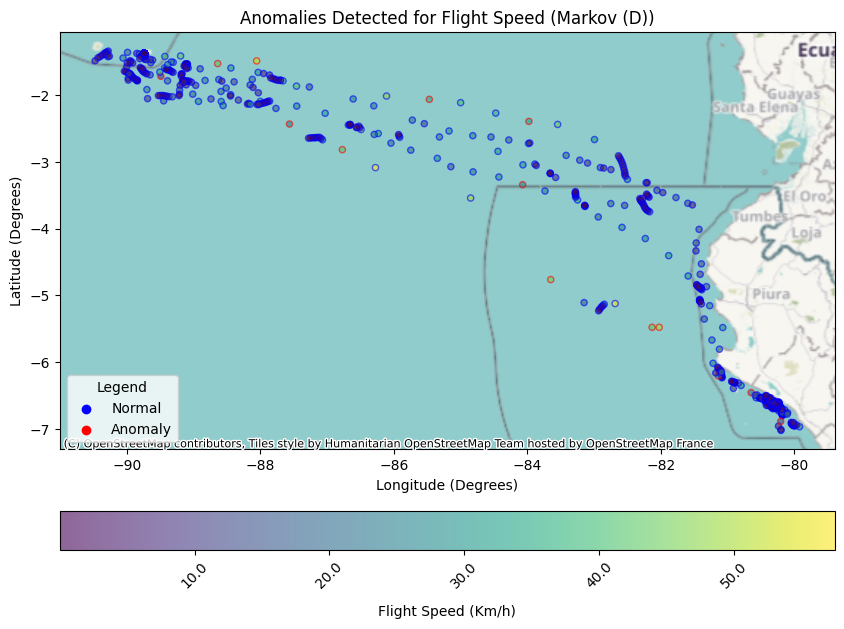

In [31]:
# Create and fit the Markov Chain model
model_mc = MarkovChainAnomalyDetector(n_states=3, n_iterations=100, random_state=50)
model_mc.fit(X_scaled)
visualize_anomalies(df_bird_161, model_mc, scaler, features, model_type='(Markov (D))')

# **Environmental Correlations**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# Define features and environmental variables
features = ['ground.speed']
environmental_vars = ['temperature_celsius', 'wind_speed']

# Assuming df_bird_161 is your dataset
X = df_bird_161[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data function
def split_data(data, train_size=0.7, val_size=0.15):
    train_end = int(len(data) * train_size)
    val_end = train_end + int(len(data) * val_size)
    return data[:train_end], data[train_end:val_end], data[val_end:]

# Split the data
X_train, X_val, X_test = split_data(X_scaled)

# Isolation Forest
if_model = IsolationForest(n_estimators=49, max_samples=200, contamination=0.025, random_state=50)
if_model.fit(X_train)
y_test_pred_if = if_model.predict(X_test)
y_test_pred_if = np.where(y_test_pred_if == 1, 0, 1)

# OCSVM
ocsvm_model = OneClassSVM(kernel='rbf', nu=0.07, gamma=0.05)
ocsvm_model.fit(X_train)
y_test_pred_ocsvm = ocsvm_model.predict(X_test)
y_test_pred_ocsvm = np.where(y_test_pred_ocsvm == 1, 0, 1)

# LSTM RNN
def reshape_for_rnn(data, time_steps):
    return np.array([data[i: i + time_steps] for i in range(len(data) - time_steps)])

time_steps = 10
X_train_rnn = reshape_for_rnn(X_train, time_steps)
X_val_rnn = reshape_for_rnn(X_val, time_steps)
X_test_rnn = reshape_for_rnn(X_test, time_steps)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(X_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_rnn, X_train_rnn, epochs=50, batch_size=32, validation_data=(X_val_rnn, X_val_rnn))

X_test_pred_rnn = model.predict(X_test_rnn)
X_test_pred_reshaped = np.repeat(X_test_pred_rnn[:, np.newaxis, :], X_test_rnn.shape[1], axis=1)
test_loss = np.mean(np.abs(X_test_rnn - X_test_pred_reshaped), axis=(1, 2))
val_threshold = np.percentile(test_loss, 95)
y_test_pred_rnn = np.where(test_loss > val_threshold, 1, 0)

# Markov Chain
class MarkovChainAnomalyDetector:
    def __init__(self, n_states=3, n_iterations=100, random_state=None):
        self.n_states = n_states
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.transition_matrix = None
        self.emission_params = None

    def fit(self, X):
        np.random.seed(self.random_state)
        if X.ndim == 2 and X.shape[1] == 1:
            X = X.ravel()
        n_samples = X.shape[0]
        self.transition_matrix = np.random.rand(self.n_states, self.n_states)
        self.transition_matrix /= self.transition_matrix.sum(axis=1, keepdims=True)
        self.emission_params = {
            'mean': np.random.rand(self.n_states),
            'std': np.random.rand(self.n_states)
        }
        for _ in range(self.n_iterations):
            responsibilities = self._compute_responsibilities(X)
            self._update_parameters(X, responsibilities)

    def _compute_responsibilities(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_states))
        for i in range(self.n_states):
            responsibilities[:, i] = np.exp(-(X - self.emission_params['mean'][i])**2 /
                                            (2 * self.emission_params['std'][i]**2)) / \
                                     (self.emission_params['std'][i] * np.sqrt(2 * np.pi))
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _update_parameters(self, X, responsibilities):
        for i in range(self.n_states):
            weight = responsibilities[:, i].sum()
            self.emission_params['mean'][i] = (responsibilities[:, i] * X).sum() / weight
            self.emission_params['std'][i] = np.sqrt(
                (responsibilities[:, i] * (X - self.emission_params['mean'][i])**2).sum() / weight
            )
        for i in range(self.n_states):
            for j in range(self.n_states):
                self.transition_matrix[i, j] = (responsibilities[:-1, i] * responsibilities[1:, j]).sum() / \
                                               responsibilities[:-1, i].sum()

    def predict(self, X, original_speeds):
        if X.ndim == 2 and X.shape[1] == 1:
            X = X.ravel()
        threshold = 16
        return np.where(original_speeds[-len(X):] >= threshold, -1, 1)

model_mc = MarkovChainAnomalyDetector(n_states=3, n_iterations=100, random_state=50)
model_mc.fit(X_scaled)
original_speeds = df_bird_161['ground.speed'].values
y_test_pred_mc = model_mc.predict(X_test, original_speeds)

# Combine predictions and calculate correlations
def calculate_correlations(df, predictions):
    anomalies_df = df[predictions == 1]
    correlation = anomalies_df[features + environmental_vars].corr()
    return correlation

# Storing Correlations in a list
correlations = {}
correlations['Isolation Forest'] = calculate_correlations(df_bird_161.iloc[len(X_train) + len(X_val):], y_test_pred_if)
correlations['OCSVM'] = calculate_correlations(df_bird_161.iloc[len(X_train) + len(X_val):], y_test_pred_ocsvm)
correlations['RNN'] = calculate_correlations(df_bird_161.iloc[len(X_train) + len(X_val) + time_steps:], y_test_pred_rnn)
correlations['Markov Chain'] = calculate_correlations(df_bird_161.iloc[len(X_train) + len(X_val):], y_test_pred_mc)

# Create prettytable for displaying correlations
table = PrettyTable()
table.field_names = ["Model", "Bird Speed (Km/h) - Temperature", "Bird Speed (Km/h) - Wind Speed"]

for model, corr in correlations.items():
    table.add_row([model, corr.at['ground.speed', 'temperature_celsius'], corr.at['ground.speed', 'wind_speed']])

print(table)